In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
files = ['results_roshambo_STL-S.csv', 'results_roshambo_STL-V.csv', 'results_roshambo_rate.csv', "results_roshambo_latency.csv"]

data = []
for f in files:
    data.append(pd.read_csv('../results/roshambo/' + f))


/Users/freek/Documents/repos/emopain-stl/.env/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/freek/Documents/repos/emopain-stl/.env/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/Users/freek/Documents/repos/emopain-stl/.env/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/freek/Documents/repos/emopain-stl/.env/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


sparsities 0.0 (nan, nan)

sparsities 0.032605416666666664 (0.01168068886591797, 0.05353014446741536)

sparsities 0.18396902777777777 (0.12743925521087962, 0.2404988003446759)

sparsities 0.20000000000000004 (0.19999999999999996, 0.20000000000000012)



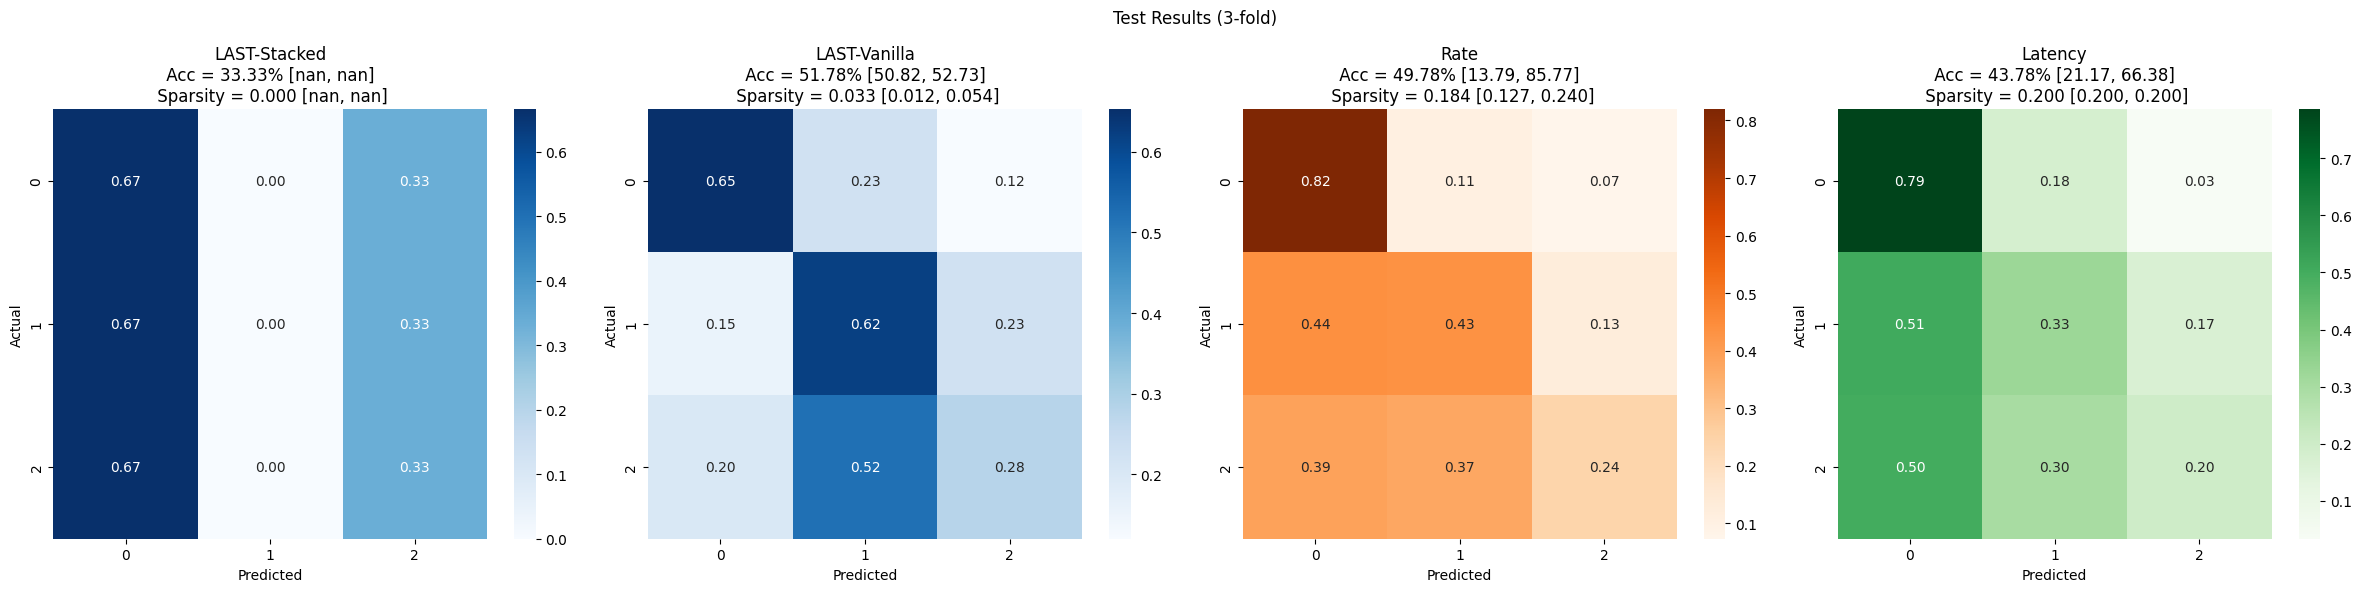

In [42]:
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix
import scipy.stats as st
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def parse_string_to_list(input_string):
    # Remove the square brackets and any extra spaces around the string
    input_string = input_string.strip("[]").replace("\n", " ")
    # Split the string by spaces and convert each element to an integer
    try:
        ans = list(map(int, input_string.split(", ")))
    except:
        ans = list(map(float, input_string.split(", ")))
    return ans

def ci(a):
    a = np.array(a)
    ci = st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))
    if ci[0] == np.nan:
        return (a.mean(), a.mean())
    else:
        return ci

fig, ax = plt.subplots(1, len(data), figsize=(6*len(data), 6))
for i, d in enumerate(data):
    f = files[i].split('.')[0]
    if "rate" in files[i]:
        r = "Rate"
        f = f.split('_')[1] + " rate"
        c = "Oranges"
        column = 2
    elif "latency" in files[i]:
        r = "Latency"
        f = f.split('_')[1] + " latency"
        c = "Greens"
        column = 3
    elif "STL-S" in files[i]:
        r = "LAST-Stacked"
        f = f.split('_')[1] + " LAST-S"
        c = "Blues"
        column = 0
    elif "STL-V" in files[i]:
        r = "LAST-Vanilla"
        f = f.split('_')[1] + " LAST-V"
        c = "Blues"
        column = 1
    
    
    test_labels = []
    test_preds = []
    cms = []
    acc = []
    sparsities = []
    aucs = []
    f1s = []
    for fold in range(3):
        test_labels.append(parse_string_to_list(d["test_labels"].values[fold]))
        test_preds.append(parse_string_to_list(d["test_preds"].values[fold]))

        acc.append(accuracy_score(test_labels[fold], test_preds[fold]))
    
        cms.append(confusion_matrix(test_labels[fold], test_preds[fold], normalize='true'))
        sparsities.append(d["sparsity"].values[fold])
        
        num_classes = np.max(test_labels) + 1
        test_labels_one_hot = np.eye(num_classes)[test_labels]
        test_preds_one_hot = np.eye(num_classes)[test_preds]
        # auc_macro = roc_auc_score(test_labels_one_hot, test_preds_one_hot, multi_class='ovr', average='macro')
        # aucs.append(auc_macro)
        
        f1 = f1_score(test_labels[fold], test_preds[fold], average="macro")
        f1s.append(f1)
        
    cms = np.array(cms)
    acc = np.array(acc)
    sparsities = np.array(sparsities)
    
    print("sparsities", sparsities.mean(), ci(sparsities))
    conf = ci(acc)

    sns.heatmap(cms.mean(axis=0), annot=True, cmap=c, fmt='.2f', ax=ax[column])
    ax[column].set_title(f"{r}\n Acc = {acc.mean()*100:.2f}% [{conf[0]*100:.2f}, {conf[1]*100:.2f}] \n Sparsity = {sparsities.mean():.3f} [{ci(sparsities)[0]:.3f}, {ci(sparsities)[1]:.3f}]")
    ax[column].set_xlabel('Predicted')
    ax[column].set_ylabel('Actual')
    
    # Compute AUC for each class and for micro and macro averages
    test_labels_flat = np.concatenate(test_labels)
    test_preds_flat = np.concatenate(test_preds)

    print()

plt.suptitle("Test Results (3-fold)")
plt.tight_layout()
plt.show()
